In [1]:
from dl_solver import Config
from data_handling import ImageNetParser
import pandas as pd

In [2]:
c = Config(is_multiproc=True)
i = ImageNetParser(c)
# 2:01

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = i.read_solution_csv("train").sample(100).pipe(i.to_jigsaw, "train")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_id          2100 non-null   object 
 1   PredictionString  2100 non-null   object 
 2   Unnamed: 0        2000 non-null   float64
 3   class_id          2100 non-null   object 
 4   cols              2097 non-null   float64
 5   height            2097 non-null   float64
 6   max_height        2097 non-null   float64
 7   max_width         2097 non-null   float64
 8   min_height        100 non-null    float64
 9   min_width         100 non-null    float64
 10  num_sample        2100 non-null   object 
 11  rows              2097 non-null   float64
 12  stochastic_nub    2097 non-null   object 
 13  width             2097 non-null   float64
dtypes: float64(9), object(5)
memory usage: 229.8+ KB


In [3]:
df = pd.read_csv(c.paths.jigsaw_dir / "train_jigsaw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      2100 non-null   int64  
 1   image_id          2100 non-null   object 
 2   PredictionString  2100 non-null   object 
 3   Unnamed: 0        2000 non-null   float64
 4   class_id          2100 non-null   object 
 5   cols              2097 non-null   float64
 6   height            2097 non-null   float64
 7   max_height        2097 non-null   float64
 8   max_width         2097 non-null   float64
 9   min_height        100 non-null    float64
 10  min_width         100 non-null    float64
 11  num_sample        2100 non-null   float64
 12  rows              2097 non-null   float64
 13  stochastic_nub    2097 non-null   object 
 14  width             2097 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 246.2+ KB


In [66]:
from pathlib import Path
from typing import Literal, Tuple, Dict

import h5py
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset


class JigsawDataset(Dataset):
    dataset_dir: Path
    split: Literal["train", "val", "test"]

    def __init__(
        self, dataset_dir: Path, split: Literal["train", "val", "test"]
    ) -> None:
        self.dataset_dir = dataset_dir
        self.split = split

        self.df = pd.read_csv(self.csv_file_path)

    @property
    def csv_file_path(self) -> Path:
        return self.dataset_dir / f"{self.split}_jigsaw.csv"

    def filter_by_shape(self, rows: int, cols: int) -> None:
        self.df = self.df.query("rows == @rows and cols == @cols")

    def get_max_segment_shape(self) -> Tuple[int, int]:
        return self.df["max_width"].max(), self.df["max_height"].max()

    def get_min_segment_shape(self) -> Tuple[int, int]:
        return self.df["min_width"].min(), self.df["min_height"].min()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> Tuple[Dict, torch.Tensor]:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        hdf5_filepath = self.dataset_dir / "images" / row["class_id"] / f"{row['num_sample']}.hdf5"

        with h5py.File(hdf5_filepath, "r") as f:
            puzzle_pieces = {
                dataset_name: torch.from_numpy(np.array(dataset))
                for dataset_name, dataset in f.items()
                if dataset_name.startswith("piece_")
            }
            labels = torch.from_numpy(np.array(f["id_row_col"]))

        return (
            puzzle_pieces,
            labels,
        )


    def plot_sample(self, idx: int) -> None:
        puzzle_pieces, labels = self[idx]
        rows = self.df.iloc[idx]["rows"]
        cols = self.df.iloc[idx]["cols"]

        fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

        # Plot each piece
        for piece in labels:
            id, row, col = piece
            axs[row, col].imshow(puzzle_pieces[f"piece_{id}"].numpy().astype(int))
            axs[row, col].axis("off")

        # Remove empty subplots
        for row in range(rows):
            for col in range(cols):
                if not axs[row, col].has_data():
                    fig.delaxes(axs[row, col])

        plt.subplots_adjust(wspace=0.0005, hspace=0.0005)
        plt.show()

    def update_min_dimensions(self) -> None:
        min_widths = []
        min_heights = []
        rows_to_drop = []

        for index, row in self.df.iterrows():
            hdf5_filepath = (
                self.dataset_dir
                / "images"
                / row["class_id"]
                / f"{int(row['num_sample'])}.hdf5"
            )
            min_width = min_height = float("inf")
            try:
                with h5py.File(hdf5_filepath, "r") as f:
                    for dataset_name, dataset in f.items():
                        if dataset_name.startswith("piece_"):
                            img = np.array(dataset)
                            min_width = min(min_width, img.shape[1])
                            min_height = min(min_height, img.shape[0])
            except Exception as e:
                # remove the row if the file is not found
                rows_to_drop.append(index)
                continue
            else:
                min_widths.append(min_width)
                min_heights.append(min_height)

        print(f"Dropping {len(rows_to_drop)} rows")
        self.df = (
            self.df
            .drop(rows_to_drop)
            .reset_index(drop=True)
            .assign(min_width=min_widths, min_height=min_heights)
            .astype(
                {
                    "min_width": "int16",
                    "min_height": "int16",
                    "max_width": "int16",
                    "max_height": "int16",
                    "width": "int16",
                    "height": "int16",
                    "rows": "uint8",
                    "cols": "uint8",
                    "image_id": str,
                    "class_id": str,
                    "num_sample": "uint32",
                    "stochastic_nub": "bool",
                }
            )
            .drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
        )

    def refurb_df(self) -> None:
        # check if each file exists
        rows_to_drop = []
        for index, row in self.df.iterrows():
            hdf5_filepath = (
                self.dataset_dir
                / "images"
                / row["class_id"]
                / f"{int(row['num_sample'])}.hdf5"
            )
            if not hdf5_filepath.exists():
                rows_to_drop.append(index)

        self.df = (
            self.df
            .drop(rows_to_drop)
            .reset_index(drop=True)
            .astype(
                {
                    "min_width": "int16",
                    "min_height": "int16",
                    "max_width": "int16",
                    "max_height": "int16",
                    "width": "int16",
                    "height": "int16",
                    "rows": "uint8",
                    "cols": "uint8",
                    "image_id": str,
                    "class_id": str,
                    "num_sample": "uint32",
                    "stochastic_nub": "bool",
                }
            )
        )

c.paths.jigsaw_dir
j = JigsawDataset(c.paths.jigsaw_dir, "train")


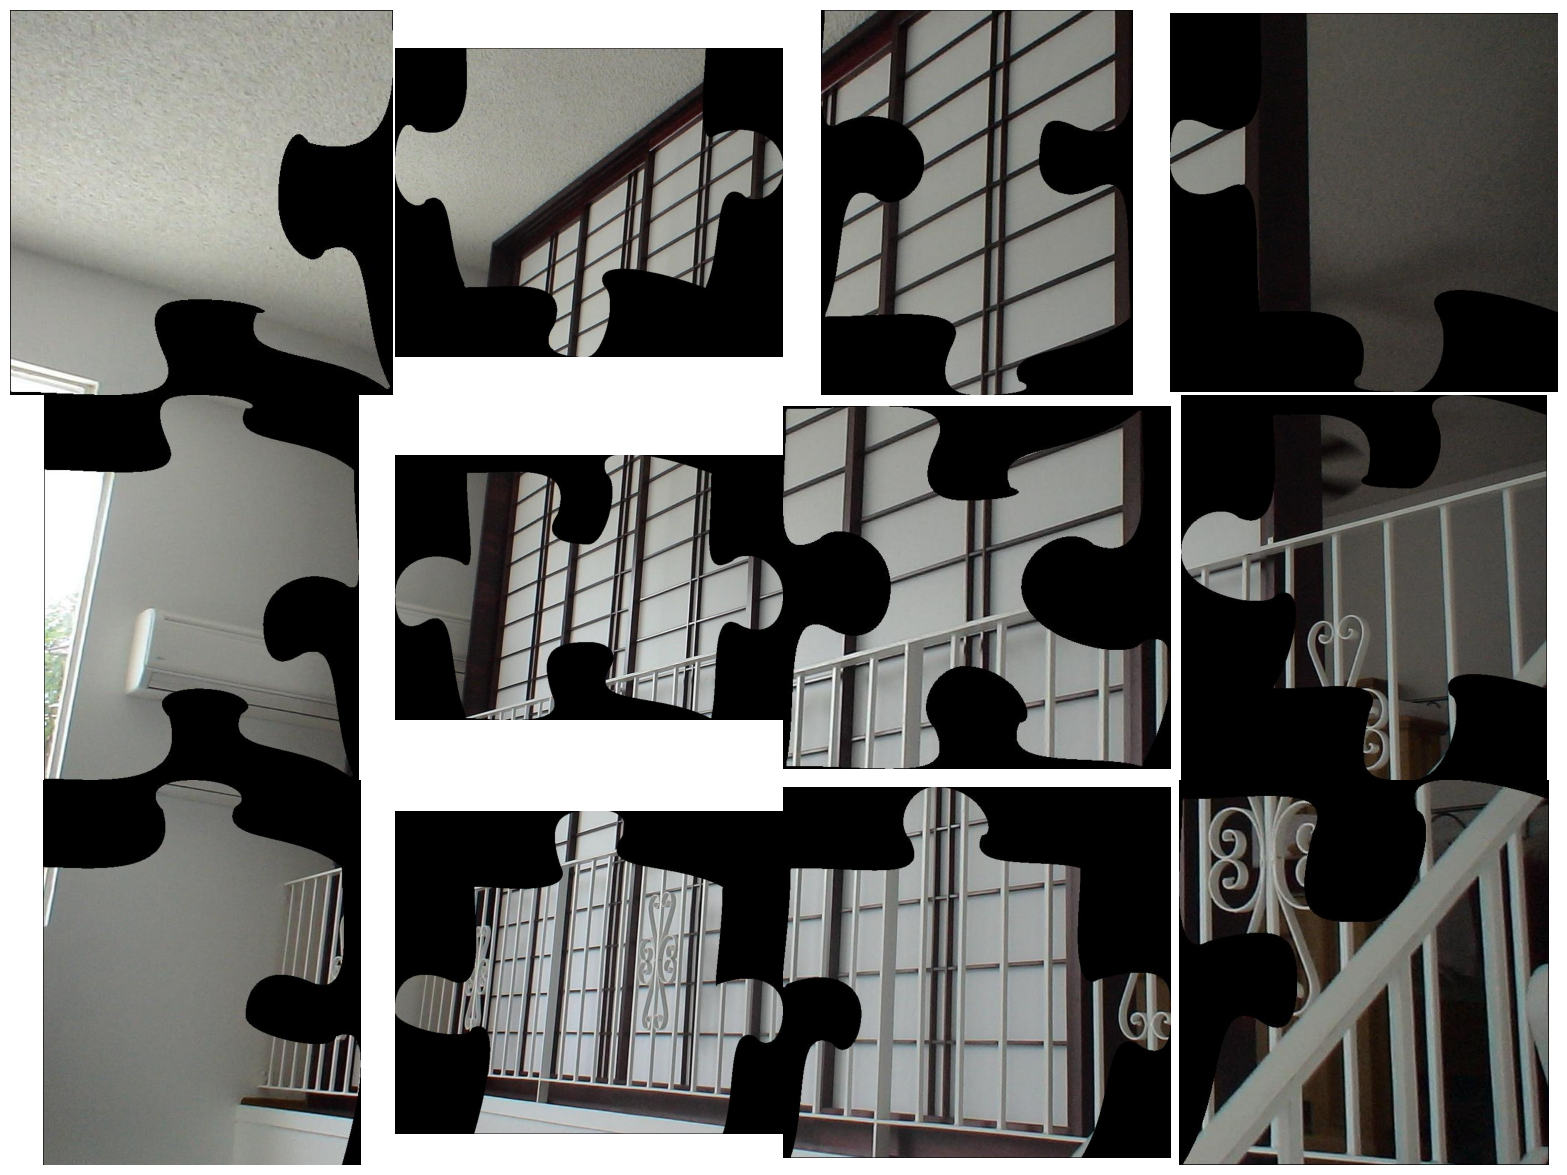

In [67]:
j.plot_sample(1643)

In [ ]:
import h5py
import numpy as np
import json

row = df.iloc[0]
hdf5_filepath =  c.paths.jigsaw_dir / row["class_id"] / f"{row['num_sample']}.hdf5"

# Open the HDF5 file
with h5py.File(hdf5_filepath, "r") as f:
    # Load metadata
    # Load all datasets into a dictionary using dictionary comprehension
    puzzle_pieces = {dataset_name: np.array(dataset) for dataset_name, dataset in f.items()}
    rows = f.attrs["rows"]
    cols = f.attrs["cols"]

In [ ]:
len(puzzle_pieces), rows, cols

(13, 3, 4)

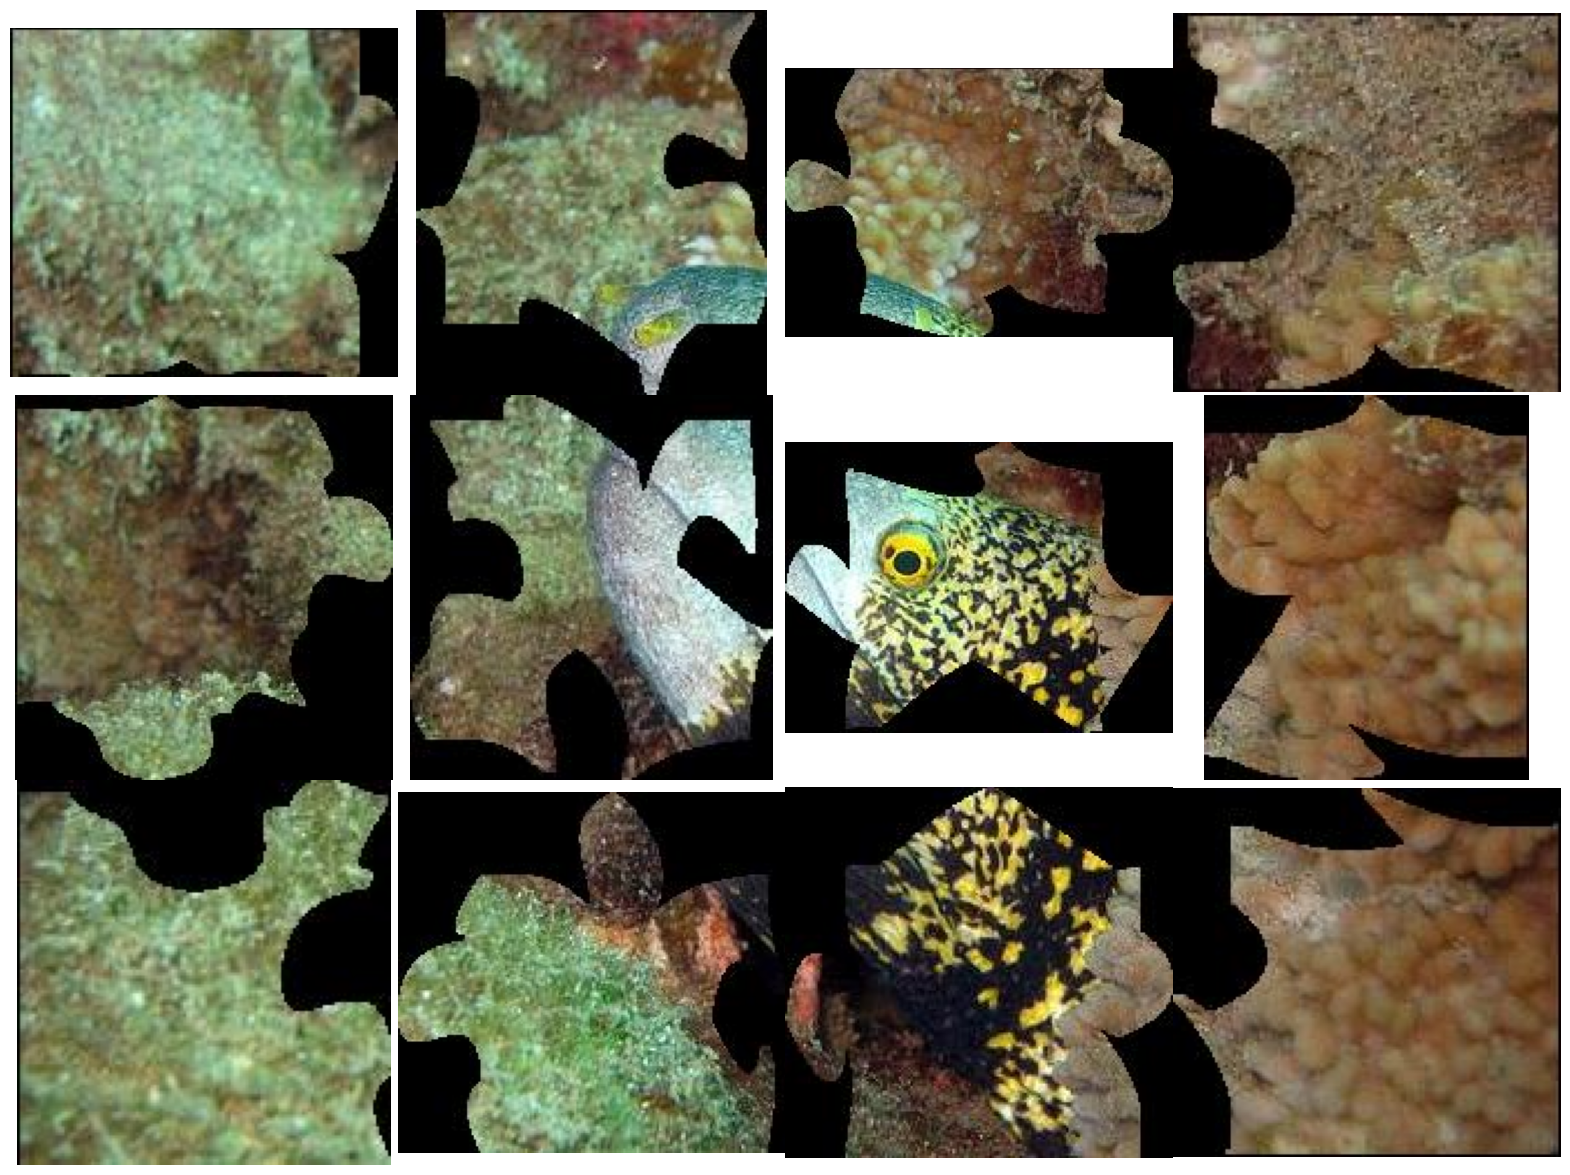

In [ ]:
from matplotlib import pyplot as plt

max_row = rows
max_col = cols

fig, axs = plt.subplots(max_row, max_col, figsize=(5*cols, 5*rows))

for piece in puzzle_pieces["id_row_col"]:
    id, row, col = piece
    axs[row, col].imshow(puzzle_pieces[f"piece_{id}"].astype(int))
    axs[row, col].axis('off')


for row in range(max_row):
    for col in range(max_col):
        if not axs[row, col].has_data():
            fig.delaxes(axs[row, col])

plt.subplots_adjust(wspace=0.0005, hspace=0.0005)
plt.show()

In [ ]:
puzzle_pieces.get("id_row_col")

array([[ 0,  0,  1],
       [ 1,  0,  3],
       [ 2,  0,  0],
       [ 3,  1,  0],
       [ 4,  1,  2],
       [ 5,  1,  1],
       [ 6,  2,  2],
       [ 7,  0,  2],
       [ 8,  1,  3],
       [ 9,  2,  0],
       [10,  2,  1],
       [11,  2,  3]])